1. Recommend a Driver's Lifetime Value (i.e., the value of a driver to Lyft over the entire projected lifetime of a driver).


2. Please answer the following questions:

    a. What are the main factors that affect a driver's lifetime value?

    b. What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long do they typically continue driving with Lyft?

    c. Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?

    d. What actionable recommendations are there for the business?


3. Prepare and submit a writeup of your findings for consumption by a cross-functional audience.

# Summary of Conclusions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
%matplotlib notebook

In [2]:
#Read in tables
drivers = pd.read_csv('driver_ids.csv')
rides = pd.read_csv('ride_ids.csv')
rides_ts = pd.read_csv('ride_timestamps.csv')
#table created in lyft_competion_cleaning.ipynb
driver_full = pd.read_csv('driver_full.csv')
driver_full = driver_full.set_index('driver_id')
#convert from string to datetime objects
drivers['driver_onboard_date'] = pd.to_datetime(drivers['driver_onboard_date'])
rides_ts['timestamp'] = pd.to_datetime(rides_ts['timestamp'])

# Driver's Lifetime Value

We believe that a driver's lifetime value should be defined by three factors: total fare revenue generated, number of prime time rides, and average pickup times. We chose this criteria because it is important that the drivers generate revenue as this is what any company relys on. We believe that number of prime time rides should be taken into consideration as it is important that these drivers work when they are most needed. We also chose to consider average pickup time as it is important the drivers are efficient with their time and provide quality customer service by not letting riders wait too long to be picked up.

### Lifetime Value = Total Revenue * (1 + tanh(Pickup Time) * .05 + tanh(Rides Per Day) * .10)

In [3]:
#normalizing values and calculating lifetime value
driver_full['lifetime_val'] = driver_full['total_fares']*(1+np.tanh(driver_full['pickup_time'].transform(
    lambda x:(x - x.mean())/x.std()))*.05+np.tanh(driver_full['rides_per_day'].transform(
    lambda x:(x - x.mean())/x.std()))*.1)

# Main Factors Affecting Driver's Lifetime Value

The main factors affecting a driver's lifetime value are ride frequency, pickup times and total fares collected. This is fairly straightforward as they are the values used in the calcualtion of a driver's lifetime value. Many other factors have a large effect on a drivers lifetime value but would be redundant to mention as they are taken into account by the total fare calculation. For example, total number of rides:

R^2 value for this model is: 0.9673281979940891


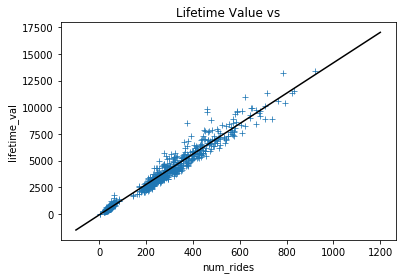

In [4]:
ax=sns.scatterplot(x='num_rides', y='lifetime_val', data=driver_full,  marker="+")
X, y = driver_full[['num_rides']], driver_full['lifetime_val']
reg = linear_model.Ridge(alpha=.01)
reg = reg.fit(X, y)
m, b = reg.coef_, reg.intercept_
ax.plot(np.linspace(-100, 1200, 100), np.linspace(-100, 1200, 100)*m+b, c='black')
ax.set(title='Lifetime Value vs')
print('R^2 value for this model is:', reg.score(X, y))

As you can see above, the number of rides a driver gives is highly correlated with their lifetime value. This makes sense as as more rides means more fares collected which is a direct contributer to lifetime value. From this we can also infer that total distance and drive time of a driver is also highly correlated with driver's lifetime value as those factors also contribute to more fares. Furthermore, number of rides during prime time and days working for Lyft also are contributers to more total fares so those factors also contribute to a greater lifetime value.

# Average Projected Lifetime of a Driver

While we could just compute the mean of the lifetime column in our driver_full table we feel this would not accuately estimate the average projected lifetime of a driver as many drivers will continue their Lyft careers beyond the data set's timeframe. This is because the datasets only span about a three month time period as seen below by finding the difference between the first and last ride timestamps:

In [5]:
max(rides_ts['timestamp']) - min(rides_ts['timestamp'])

Timedelta('90 days 19:02:32')

Knowing this limitation we decided on using this formula to project an average lifetime:
### Projected Lifetime = 1 / (Churn Rate)

To calculate the churn rate, the percentage of people who have decided not to stay with Lyft over the three month period, we calculated the percent of people inactive for more than seven days, meaning that they did not give a ride in the last week of the dataset.

In [6]:
churn_rate = np.count_nonzero(
    [driver_full['time_inactive']>7])/len(driver_full)
proj_lifetime = 1/(churn_rate)
proj_lifetime

2.735294117647059

We must then multiply this number by three becuase the churn rate was calcuated over a three month period:

In [7]:
proj_lifetime*3

8.205882352941178

Using this formula we get that the projected lifetime of a driver is around 8.2 months.

# Do All Drivers Act Alike?

In order to answer this question we have decided to use the k-means clustering algorithm to find groups (clusters) in the data. After some experimentation we found that the data can be seperated into three different clusters.

Here we use a normalized version of the driver_full table to apply the k-means clustering algorithm:

In [8]:
#Normalizing Values
driver_norm = driver_full.copy()
driver_norm = driver_norm.transform(lambda x:(x - x.mean())/x.std())
X = driver_norm.values
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
driver_full['group'] = labels

In [9]:
experienced = driver_full[driver_full['group']==2]
average = driver_full[driver_full['group']==0]
starting = driver_full[driver_full['group']==1]
groups = {2:'experienced', 0:'average', 1:'starting'}
driver_full['group'] = driver_full['group'].apply(
    lambda x:groups[x])

To get an idea of what the clustering looks like we can plot the clusters and the columns which we used to compute lifetime value.

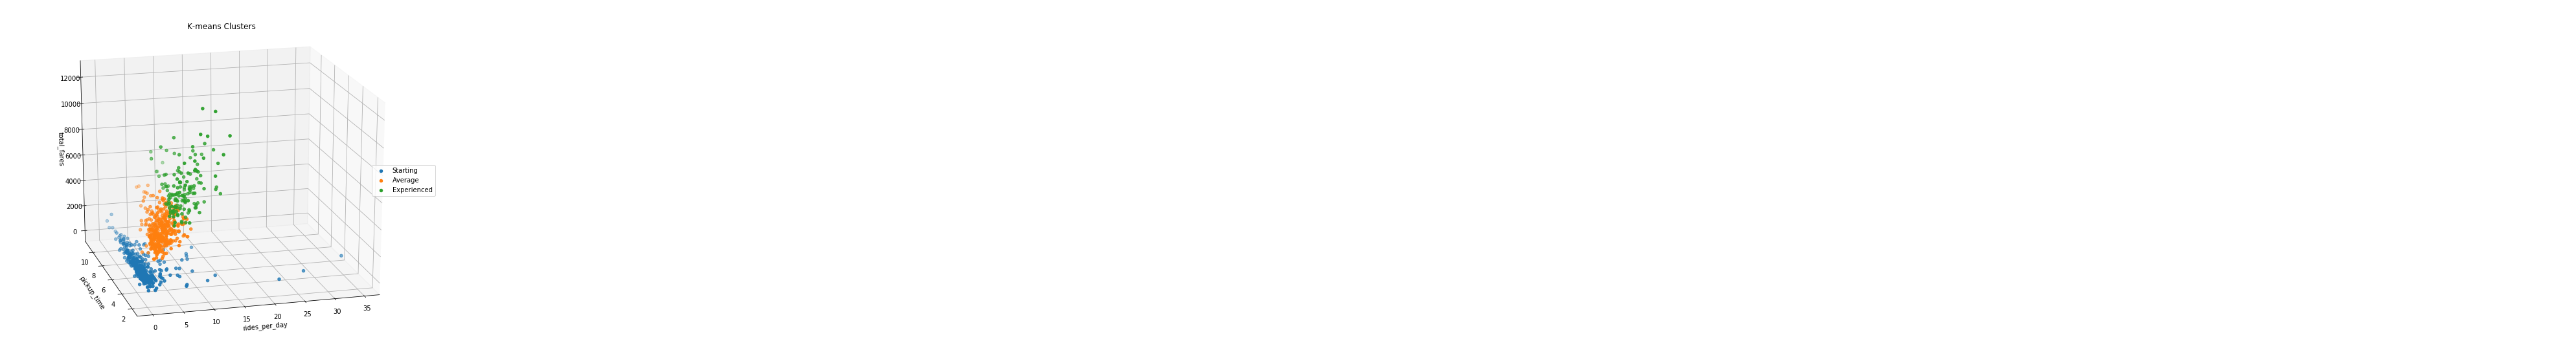

In [10]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(starting['rides_per_day'], starting['pickup_time'],
           starting['total_fares'], label='Starting')
ax.scatter(average['rides_per_day'], average['pickup_time'],
           average['total_fares'], label='Average')
ax.scatter(experienced['rides_per_day'], experienced['pickup_time'],
           experienced['total_fares'], label='Experienced')
ax.set_xlabel('rides_per_day')
ax.set_ylabel('pickup_time')
ax.set_zlabel('total_fares')
ax.view_init(20, 255)
ax.legend(loc='center right')
ax.set(title='K-means Clusters')
plt.gca().patch.set_facecolor('white')
plt.show()

As seen above we have three clusters representing what we believe to be three different types of driver. We have starting drivers, average drivers and experienced drivers. Below we will explore the differences between these groups:

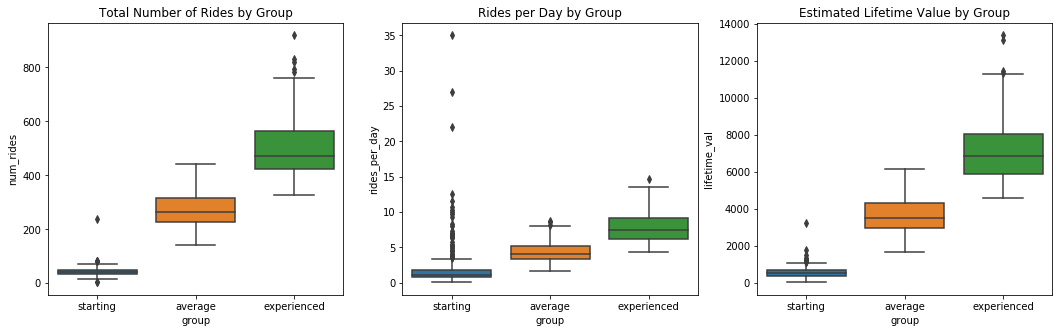

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(x="group", y="num_rides", data=driver_full, ax=ax1, order=['starting', 'average', 'experienced'])
ax1.set(title='Total Number of Rides by Group')
sns.boxplot(x="group", y="rides_per_day", data=driver_full, ax=ax2, order=['starting', 'average', 'experienced'])
ax2.set(title='Rides per Day by Group')
sns.boxplot(x="group", y="lifetime_val", data=driver_full, ax=ax3, order=['starting', 'average', 'experienced'])
ax3.set(title='Estimated Lifetime Value by Group')
plt.show()

The starting driver group is the most sporadic of all the groups with the most outliers. Generally, starting drivers have around 50 total rides and around 2-3 rides per day. These drivers have a very low estimated lifetime values around 500 dollars. The average drivers have a much larger amount of total rides of around 150 and give around 4-5 rides per day. These drivers have an estimated lifetime value of around 3000 dollars. Lastly, we have the experienced drivers. These drivers are the most important to the company as they have the most total rides, rides per day, and estimated lifetime value, on average. This group has around 475 total rides and gives around 7-8 rides per day with an estimated lifetime value of around 7000 dollars. Below we will explore the contributions of each group to the company.

In [12]:
#method to add percentages to the charts below
def add_percent(ax, total, height_change):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + height_change,
                '{:1.2f}'.format(height/total),
                ha="center") 

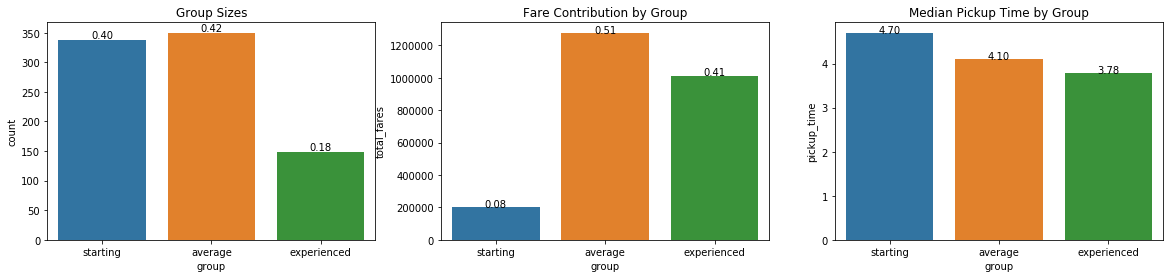

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
sns.countplot(x='group', data=driver_full, order=['starting', 'average', 'experienced'], ax=ax1)
ax1.set(title='Group Sizes')
add_percent(ax1, len(driver_full), 3)

sns.barplot(x='group', y='total_fares', estimator=np.sum, data=driver_full, ci=None,
                  order=['starting', 'average', 'experienced'], ax=ax2)
ax2.set(title='Fare Contribution by Group')
add_percent(ax2, np.sum(driver_full['total_fares']), 3)

sns.barplot(x='group', y='pickup_time', estimator=np.median, data=driver_full, ci=None,
            order=['starting', 'average', 'experienced'], ax=ax3)
ax3.set(title='Median Pickup Time by Group')
add_percent(ax3, 1, 0)
plt.show()

Above we see that the second largest group is the starting drivers. These drivers make up 40% of the Lyft drivers but only contribute to 8% of the total fare revenue and have the worst median pickup times. The largest group, the average drivers generate a little over half of the total fare revenue with a better median pickup time than the starting group. The smallest group, the experience drivers make up 18% of the Lyft drivers but contribute 41% of total fare revenue. The experienced group also has the best median pickup time.

# Business Recommendations